In [2]:
import os
import io
import requests
from datetime import datetime
import configparser
import numpy as np
import matplotlib.pyplot as plt
import xarray
import rasterio as rs
from rasterio import plot, mask
from rasterio.features import rasterize
from rasterio.enums import Resampling
import rioxarray

from shapely import Polygon, LineString

import geopandas as gpd
import pandas as pd

import pyTMD

In [9]:
def reproject_raster(src, target_crs):
    '''
    Change crs of imported data
    '''
    
    src_crs = src.crs
    src_transform = src.transform
    src_width = src.width
    src_height = src.height

    # Define the target CRS
    target_crs = target_crs

    # Reproject the raster data to the target CRS
    reprojected_data, dst_transform = rs.warp.reproject(
        source=rs.band(src, 1),
        src_transform=src_transform,
        src_crs=src_crs,
        dst_crs=target_crs,
        resampling=rs.enums.Resampling.nearest)
    
    return reprojected_data, dst_transform, target_crs

def get_REMA_mdf_date(ini_path, num_lines=50):
    '''
    parse a fake ini file by adding a dummy section header
    Only will work for the REMA mdf files
    '''
    config = configparser.ConfigParser()
    # Add a dummy section header to the file before parsing
    with open(ini_path, 'r') as file:
        #content = '[dummy_section]\n' + "".join(file.readlines()[:num_lines])
        content = '[dummy_section]\n' + "".join([l.strip('\t \n ;')+'\n' for l in file.readlines()[:30]])
        config.read_string(content)
        # get the datetime for the acquisitions, round to the minute
        try: dem_date = datetime.strptime(config.get('dummy_section', 'avgacqtime1'), '%Y-%m-%d %H:%M:%S')
        except: 
            print('Exception: extra character found')
            dem_date = datetime.strptime(config.get('dummy_section', 'avgacqtime1'), '%Y-%m-%d %H:%M:%S;')
    return dem_date

def get_mesh_grid(src, transform):
    height, width = src.height, src.width
    x_coords = np.linspace(transform[2], transform[2] + transform[0] * width, width)
    y_coords = np.linspace(transform[5], transform[5] + transform[4] * height, height)
    xx, yy = np.meshgrid(x_coords, y_coords)
    return xx, yy

In [4]:
'''
for when im **ready** to loop through all the DEMs
for dem in dem_list:
    file_name = f'{dem}/{dem}_dem.tif'
    # code to open dem and do stuff
'''  

"\nfor when im **ready** to loop through all the DEMs\nfor dem in dem_list:\n    file_name = f'{dem}/{dem}_dem.tif'\n    # code to open dem and do stuff\n"

In [10]:
%%time

# get list of DEMs to process
dem_list = np.array(os.listdir('../data/larsenc/'))
dem_list = dem_list[np.array([d.startswith('S') for d in dem_list])]


# load first DEM
dem_name = dem_list[0]
print(f'Opening {dem_name}')
dem_date = f'{dem_name[18:22]}-{dem_name[22:24]}-{dem_name[24:26]}'
file_path = f'../data/larsenc/{dem_name}/{dem_name}_dem.tif'
meta_path = f'../data/larsenc/{dem_name}/{dem_name}_mdf.txt'
with rs.open(file_path) as src:
    dem = src.read()
    tr = src.transform
    xx, yy = get_mesh_grid(src, tr)
    src, tr, crs = reproject_raster(src, 'EPSG:3031')

#Get Metadata (date and time)

dem_date = get_REMA_mdf_date(meta_path)

Opening SETSM_s2s041_WV01_20210213_10200100A4E07300_10200100A6476500_2m_lsf_seg2
CPU times: user 33.6 s, sys: 7.81 s, total: 41.4 s
Wall time: 44.8 s


In [ ]:
%%time
dem_arr = np.full(xx.shape, dem_date)
x, y, dt = xx, yy, dem_arr.astype('datetime64[us]')
path_to_tide_models = '../data/'
tide_h = np.reshape(pyTMD.compute_tide_corrections(x, y, dt,
    DIRECTORY=path_to_tide_models, correction='ocean',
    MODEL='CATS2008-v2023', EPSG=3031, EPOCH=pd.Timestamp('1970-01-01 00:00:00'),
    TYPE='drift', TIME='datetime',
    METHOD='spline', FILL_VALUE=np.nan), xx.shape, order='C')

In [ ]:
plt.scatter(x, y, c=tide_h)
plt.colorbar()

In [221]:
tide_h.shape

(25,)

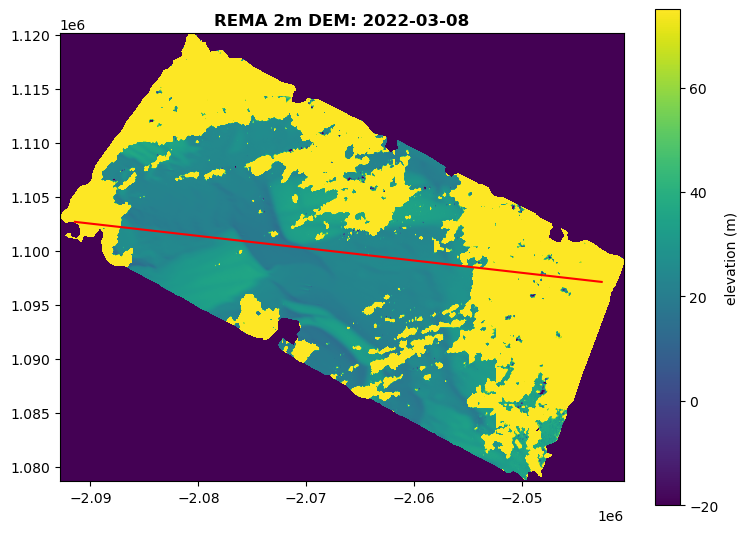

In [5]:
vmin, vmax = -20, 75
titl = f'REMA 2m DEM: {dem_date.date()}'
#xlim = [2.5675e6, 2.5850e6]
#ylim = [-457000, -435000]

######################

fig, ax = plt.subplots(figsize=[8, 8])
# has some kwargs but also passes some to plt.imshow()
img = plot.show(src, ax=ax, transform=tr, cmap='viridis', title=titl, vmin=vmin, vmax=vmax, aspect='equal')
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

#gj.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, fraction=0.04)
cbar.set_label('elevation (m)')

line_coords_00 = [[-2091439,1102697], [-2042601,1097128]]
x, y = LineString(line_coords_00).xy
ax.plot(x, y, color='red')

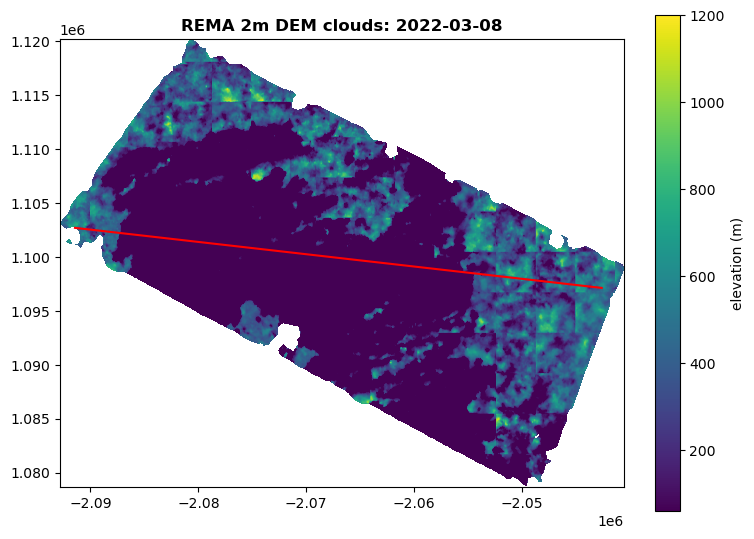

In [22]:
vmin, vmax = 60, 1200
titl = f'REMA 2m DEM clouds: {dem_date.date()}'
#xlim = [2.5675e6, 2.5850e6]
#ylim = [-457000, -435000]

######################

fig, ax = plt.subplots(figsize=[8, 8])
# has some kwargs but also passes some to plt.imshow()
img = plot.show(src, ax=ax, transform=tr, cmap='viridis', title=titl, vmin=vmin, vmax=vmax, aspect='equal')
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

#gj.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, fraction=0.04)
cbar.set_label('elevation (m)')

line_coords_00 = [[-2091439,1102697], [-2042601,1097128]]
x, y = LineString(line_coords_00).xy
ax.plot(x, y, color='red')

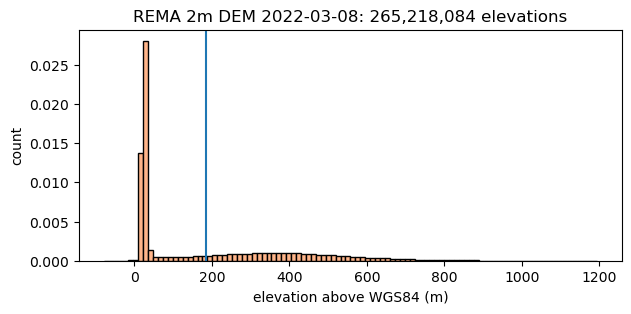

In [7]:
dat_flat = np.ndarray.flatten(src[0])
dat = dat_flat[(dat_flat>-2000)*(dat_flat<1e6)]
plt.figure(figsize=[7, 3])
length = len(dat)
plt.hist(dat, 100, density=True, color='#ffb58a', edgecolor='black')
#plt.hist(dat[dat>-2000], 100, density=False, color='#ffb58a', edgecolor='black')
plt.xlabel('elevation above WGS84 (m)')
plt.ylabel('count')
plt.title(f'REMA 2m DEM {dem_date.date()}: {length:,} elevations')
#plt.xlim([-9, 69])
plt.axvline(x=np.mean(dat))

Text(0.5, 1.0, 'REMA 2m DEM from 2022-03-08: 24,420 elevations')

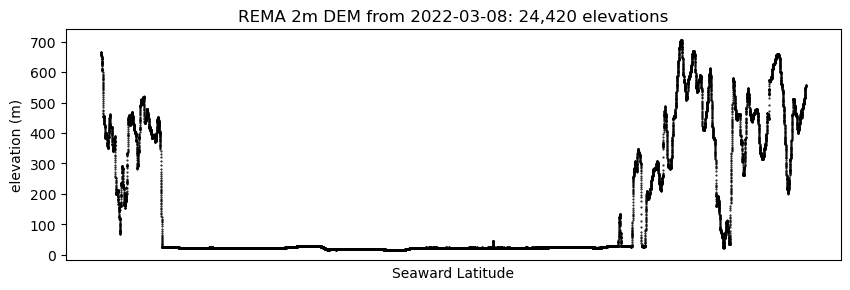

In [8]:
mask = rasterize([LineString(line_coords_00)], out_shape=src.shape[1:], transform=tr)
dat = src[0]
track = dat[mask==1]
length = len(track)

plt.figure(figsize=[10, 3])
plt.plot(track[:], '.', color='black', linewidth=2, markersize=1)
#plt.ylim([-10, 55])
#plt.xlim([0,2900]) 
plt.ylabel('elevation (m)')
plt.xticks([])
plt.xlabel('Seaward Latitude')
plt.title(f'REMA 2m DEM from {dem_date.date()}: {length:,} elevations')